In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

In [3]:
data_dir = './dataset'
os.environ['SSL_CERT_FILE'] = '/Users/alix/PycharmProjects/SmartBin/.venv/lib/python3.11/site-packages/certifi/cacert.pem'

In [4]:
# review number of files and directories in the dataset
total_dir = len(os.listdir(data_dir))
total_files = 0

for dirname, _, filenames in os.walk(data_dir):
    print('counting:', dirname)
    files_counter = 0
    for file in filenames:
        files_counter += 1
    total_files += files_counter
    print('total files in dir:', files_counter)

print('--------')
print('total number of files',total_files)
print('total number of directories',total_dir)

counting: ./dataset
total files in dir: 0
counting: ./dataset/organic
total files in dir: 3499
counting: ./dataset/glass
total files in dir: 3511
counting: ./dataset/recyclable
total files in dir: 3575
--------
total number of files 10585
total number of directories 3


In [5]:
# create datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=100
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=100
)

Found 10585 files belonging to 3 classes.
Using 8468 files for training.
Found 10585 files belonging to 3 classes.
Using 2117 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['glass', 'organic', 'recyclable']


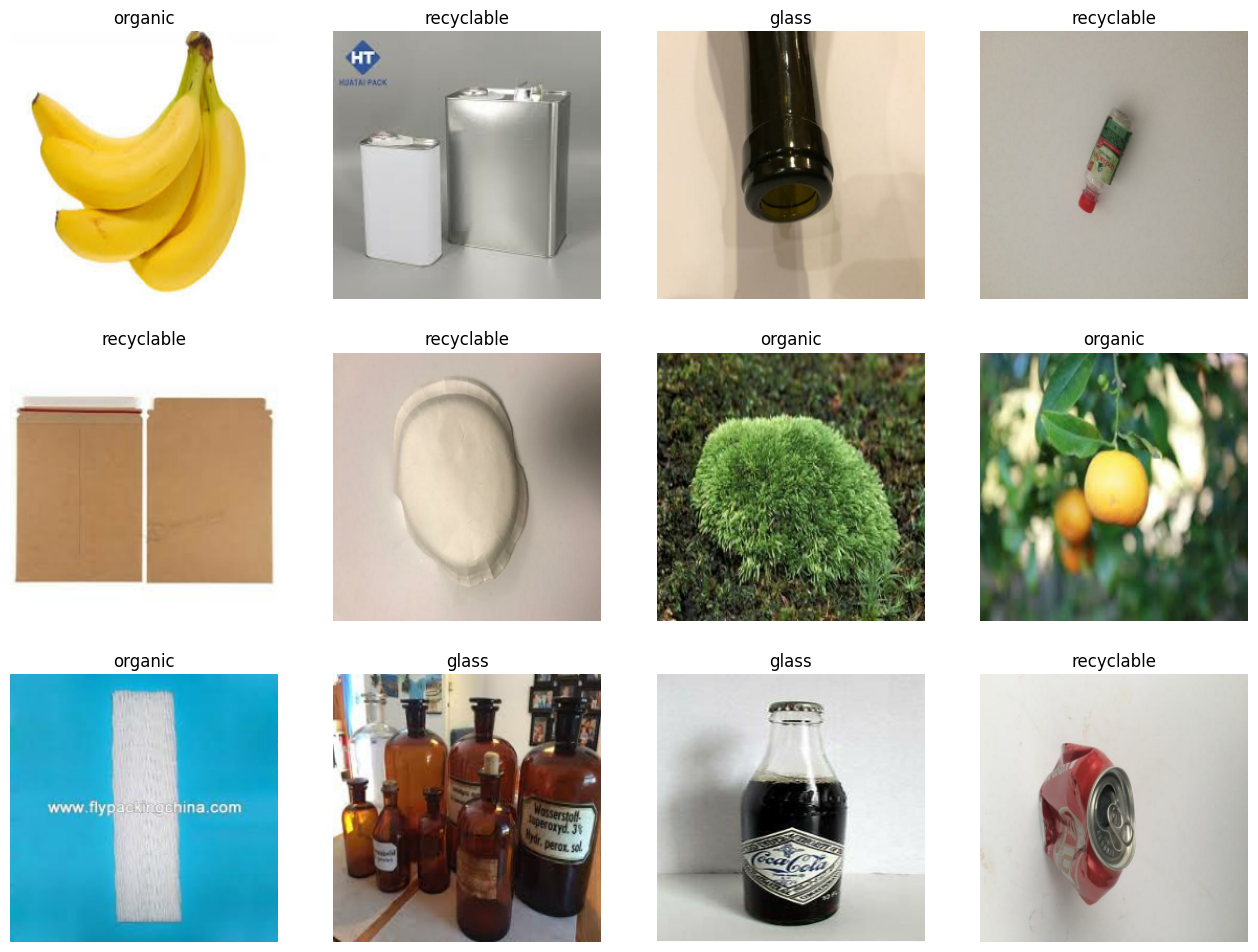

In [7]:
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

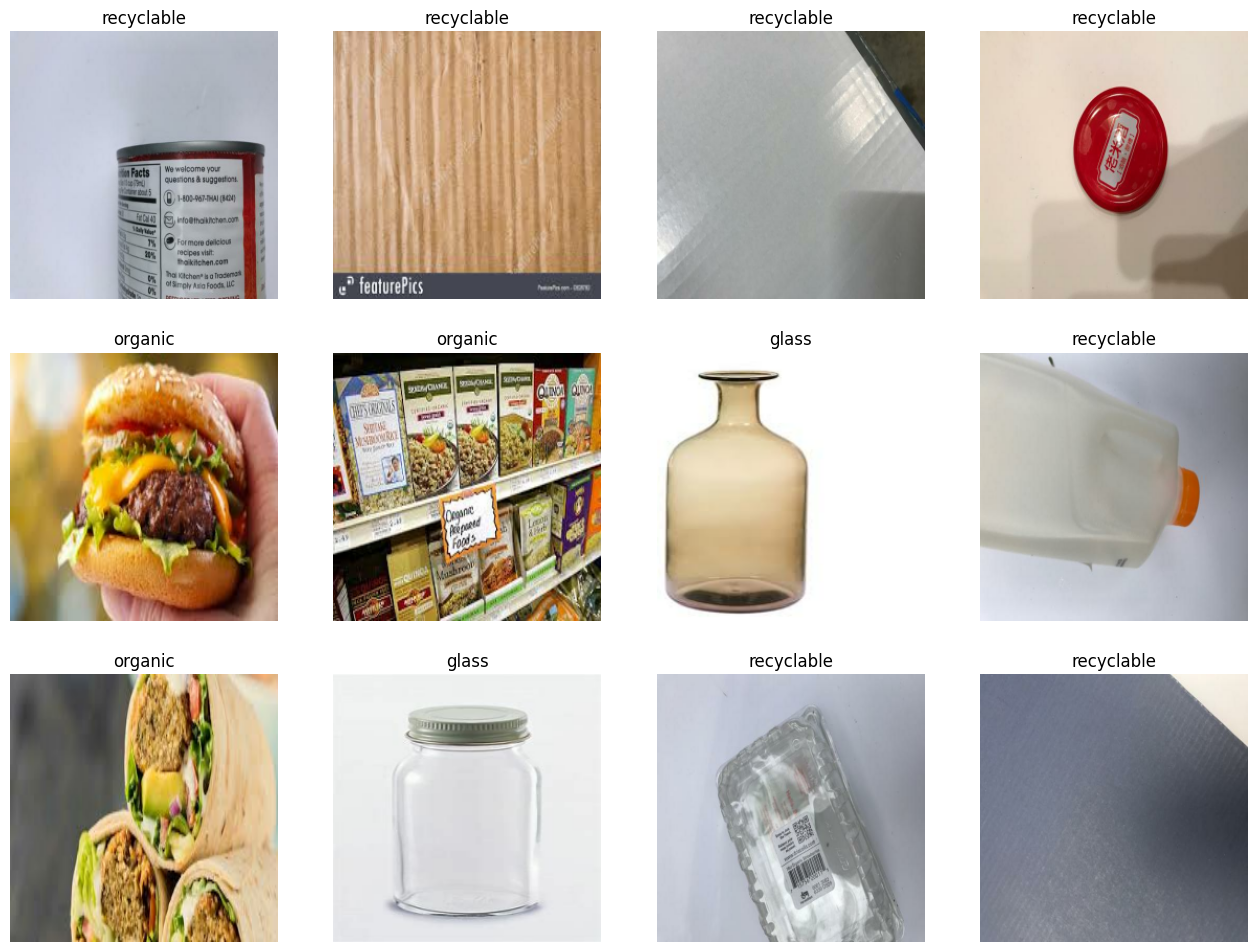

In [8]:
# view some images from the validation_ds
plt.figure(figsize=(16, 16))
for images, labels in validation_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
# inspect the train_ds
train_batch = train_ds.as_numpy_iterator().next()

print('total of batches:',len(train_ds))
print('images batch shape:',train_batch[0].shape)
print('labels batch shape:',train_batch[1].shape)

total of batches: 265
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [10]:
# inspect the validation_ds
validation_batch = validation_ds.as_numpy_iterator().next()

print('total of batches:',len(validation_ds))
print('images batch shape:',validation_batch[0].shape)
print('labels batch shape:',validation_batch[1].shape)

total of batches: 67
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [11]:
# instantiate the base model
input_shape = (256,256,3)
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape)

# make the layers of the model trainable to fine-tunning
base_model.trainable = True

In [12]:
# review the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [13]:
# find the tunning layer and its index
tuning_layer_name = 'conv5_block1_preact_bn'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

# freeze all the layers before the tuning layer
for layer in base_model.layers[:tuning_index]:
    layer.trainable =  False

In [14]:
# Créer une étape d'augmentation de données avec des retournements horizontaux et verticaux, des rotations et des zooms
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset= -1), 
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name='data_augmentation')

# Créer le modèle de réseau neuronal
model = tf.keras.Sequential([
    data_augmentation,
    # tf.keras.layers.Input(shape=input_shape),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Définir le taux d'apprentissage
learning_rate = 0.00001

# Compiler le modèle avec l'optimiseur Adam en spécifiant le taux d'apprentissage
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),  # Spécifier learning_rate ici
    metrics=['accuracy']
)

In [44]:
# train the model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=15
)

Epoch 1/15
265/265 [==============================] - 752s 3s/step - loss: 0.8568 - accuracy: 0.7048 - val_loss: 0.3722 - val_accuracy: 0.8781
Epoch 2/15
265/265 [==============================] - 744s 3s/step - loss: 0.3769 - accuracy: 0.8706 - val_loss: 0.2690 - val_accuracy: 0.9121
Epoch 3/15
265/265 [==============================] - 764s 3s/step - loss: 0.2866 - accuracy: 0.9021 - val_loss: 0.2168 - val_accuracy: 0.9310
Epoch 4/15
265/265 [==============================] - 754s 3s/step - loss: 0.2395 - accuracy: 0.9160 - val_loss: 0.1851 - val_accuracy: 0.9381
Epoch 5/15
265/265 [==============================] - 746s 3s/step - loss: 0.1975 - accuracy: 0.9325 - val_loss: 0.1656 - val_accuracy: 0.9405
Epoch 6/15
265/265 [==============================] - 736s 3s/step - loss: 0.1760 - accuracy: 0.9382 - val_loss: 0.1519 - val_accuracy: 0.9447
Epoch 7/15
265/265 [==============================] - 707s 3s/step - loss: 0.1529 - accuracy: 0.9450 - val_loss: 0.1389 - val_accuracy: 0.9499

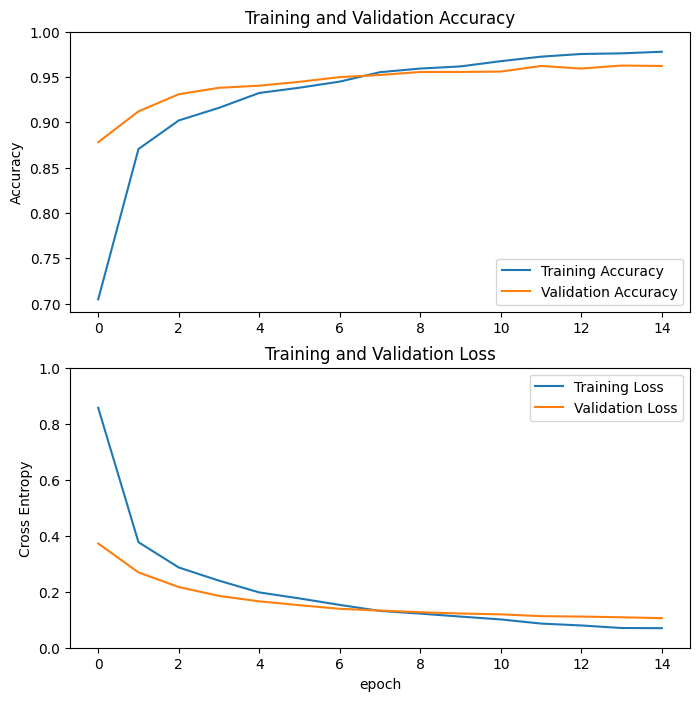

In [45]:
# visualize the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# plot loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
# verify the performance of the model
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

67/67 [==============================] - 90s 1s/step - loss: 0.1056 - accuracy: 0.9622
Test accuracy : 0.9622106552124023
Test loss: 0.10561010986566544


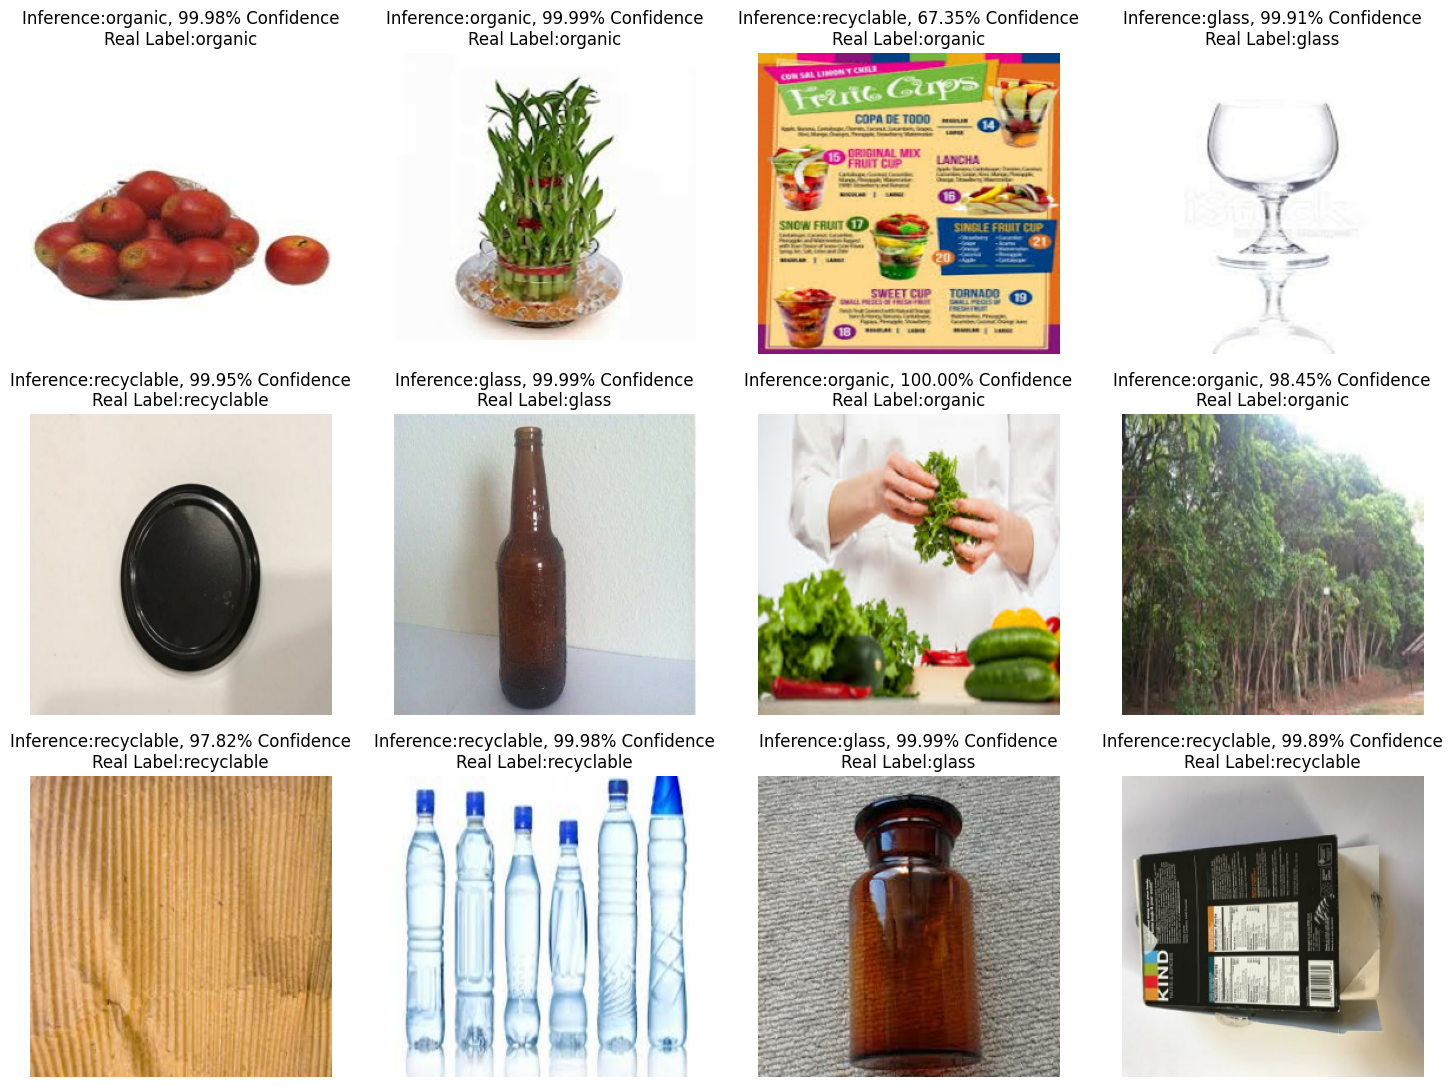

In [47]:
# get a batch from validation_ds to do some inference
image_batch, label_batch = validation_ds.as_numpy_iterator().next()

# inference
inference = model.predict_on_batch(image_batch)

# show imgs and labels
plt.figure(figsize=(18, 18))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title('Inference:{}, {:.2f}% Confidence\nReal Label:{}'
              .format(class_names[np.argmax(inference[i])], 100 * np.max(inference[i]), class_names[label_batch[i]]))
    plt.axis("off")

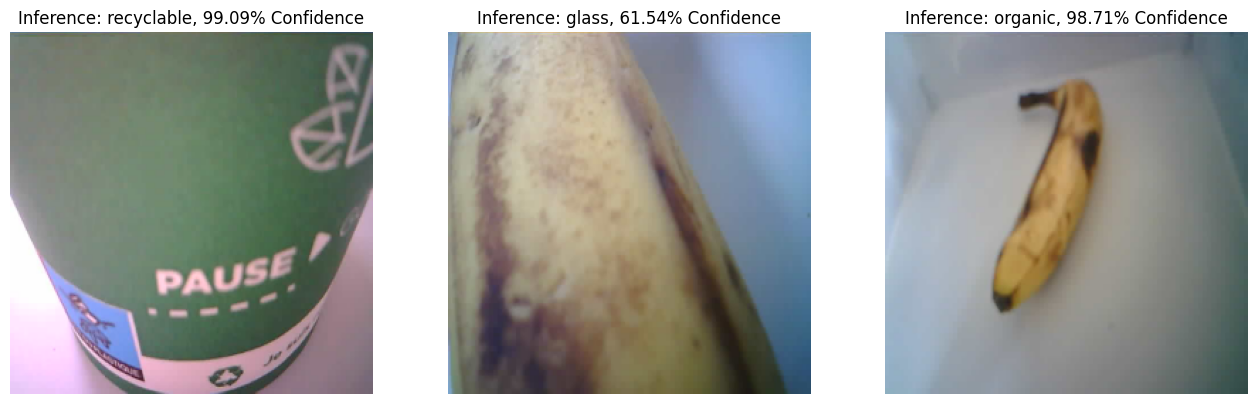

In [22]:
from keras.src.saving.saving_api import load_model
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

model = load_model('model.keras')
image_folder = 'test-images/'
data_dir = './dataset'

# Chemins des images locales
local_image_paths = [
    'test-images/1712932123794.jpg',
    'test-images/1712932976996.jpg',
    'test-images/1712933943779.jpg',
]

# model = None
# model = tf.keras.models.load_model('alex.keras', compile=False)

# # Créer le dataset de test
test_ds = []
image_size = (256, 256)
for path in local_image_paths:
    img = cv2.imread(path)  # Charger l'image à partir du chemin local
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB (Matplotlib utilise RGB)
    img = cv2.resize(img, image_size)  # Redimensionner l'image
    test_ds.append(img)
test_ds = np.array(test_ds)

# Inférence
test_inference = model.predict_on_batch(test_ds)

# Afficher les images avec les prédictions
plt.figure(figsize=(16, 16))
for i in range(len(local_image_paths)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_ds[i].astype("uint8"))
    plt.title('Inference: {}, {:.2f}% Confidence'
              .format(class_names[np.argmax(test_inference[i])], 100 * np.max(test_inference[i])))
    plt.axis("off")

plt.show()

In [49]:
model.save('model.keras')